In [288]:
import pandas as pd
import numpy as np
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import mean_squared_error
from IPython.display import display

# Data ingestion

In [289]:
url = 'https://nyc-tlc.s3.amazonaws.com/trip+data/'
files = ['fhv_tripdata_2021-01.parquet', 'fhv_tripdata_2021-02.parquet']
data_sources = [url + file for file in files]
data_destinations = ['./data/' + file for file in files]

In [290]:
for i in range(len(data_sources)):
    source = data_sources[i]
    destination = data_destinations[i]
    print(f'Downloading {data_sources[i]}')
    !curl $source -o $destination --create-dirs 

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  2 11.3M    2  237k    0     0   265k      0  0:00:43 --:--:--  0:00:43  265k
 12 11.3M   12 1495k    0     0   814k      0  0:00:14  0:00:01  0:00:13  815k
 26 11.3M   26 3025k    0     0  1057k      0  0:00:10  0:00:02  0:00:08 1057k
 40 11.3M   40 4674k    0     0  1211k      0  0:00:09  0:00:03  0:00:06 1211k
 53 11.3M   53 6221k    0     0  1286k      0  0:00:09  0:00:04  0:00:05 1286k
 68 11.3M   68 7904k    0     0  1348k      0  0:00:08  0:00:05  0:00:03 1543k
 83 11.3M   83 9655k    0     0  1408k      0  0:00:08  0:00:06  0:00:02 1626k
 98 11.3M   98 11.1M    0     0  1460k      0  0:00:07  0:00:07 --:--:-- 1691k
100 11.3M  100 11.3M    0     0  1464k      0  0:00:07  0:00:07 --:--:-- 1705k
  % Total    % Received % Xferd  Average Speed   Ti

# Data preparation
- Look at the data
- Make column names and values look uniform
- Check if all the columns read correctly
- Check and transform types - categorical/numerical features

In [334]:
def read_dataframe (data_file, categorical_features=None, numerical_features=None, target=None, verbose=False):
    
    if (verbose): print(f'Pre-processing dataset {data_file}')
    df = pd.read_parquet(data_file)
    if (verbose): print(f'shape: {df.shape}')
    df.columns.str.lower().str.replace(' ','_')
    if (verbose): print(f'types:\n{df.dtypes}')
    
    categorical_columns = list(df.dtypes[df.dtypes == 'object'].index)
    numerical_columns = list(df.dtypes[df.dtypes != 'object'].index)
    
    for column in categorical_columns:
        # This will not touch the None values, only the not None types are processed (type(df['store_and_fwd_flag'].iloc[-1]) => 'NoneType')
        df[column] = df[column].str.lower().str.replace(' ', '_')

    df['duration'] = (df['dropOff_datetime'] - df['pickup_datetime']).dt.seconds / 60

    if verbose:
        display(df.head().T)
        print(f'types:\n{df.dtypes}')
        print('\nUniques values\n')
        
        for c in df.columns:
            display(c, df[c].unique())
            
        print('\ncategorical_columns\n')
        for column in categorical_columns:
            display(f'Feature: {column}')
            display(f'Number of unique values: {df[column].nunique()}')
            display(f'Number of nulls: {df[column].isnull().sum()}')
            display(df[column].value_counts(normalize=True))
            
        print('\nnumerical_columns\n')
        for column in numerical_columns:
            display(f'Feature: {column}')
            nuniques = df[column].nunique()
            display(f'Number of unique values: {nuniques}')
            display(f'Number of nulls: {df[column].isnull().sum()}')
            if nuniques < 20:
                display(df[column].value_counts(normalize=False))
        
        sns.displot(df.duration, kind='kde')
        print(df['duration'].describe(percentiles=[0.1, 0.2, 0.95, 0.98, 0.99]))
        print(f'% of trips within 1-60 min: {((df.duration >= 1) & (df.duration<=60)).mean()}')
    
    if (verbose): print('\nFiltering by duration...')
    df = df[(df.duration >= 1) & (df.duration<=60)]
    if (verbose): print(f'shape: {df.shape}')

    for column in ['PUlocationID', 'DOlocationID']:
        if (verbose): print(f'\nFilling {round(df[column].isna().mean()*100,2)}% of nans with -1 in column: {column}')
        df[column].fillna(-1, inplace=True)
        
    if not categorical_features:
        categorical_features = ['PUlocationID', 'DOlocationID']
    if not numerical_features:
        numerical_features =  []
    if not target:
        target = ['duration']
    df[categorical_features] = df[categorical_features].astype('str')
    df.drop(df.columns.difference(categorical_features+numerical_features+target), axis=1, inplace=True)    
    
    if verbose:
        print(f'\nfinal shape: {df.shape}')
        print(f'\nfinal types:\n{df.dtypes}')
        print(f'\ncategorical_features: {categorical_features}')
        print(f'\nnumerical_features: {numerical_features}')
        print(f'\ntarget: {target}')       
    
    return df[categorical_features+numerical_features],df[target] 
    

# Data Reading and preparation from function

In [335]:
categorical_features = ['PUlocationID', 'DOlocationID']
numerical_features=  []
target = ['duration']

Pre-processing dataset https://nyc-tlc.s3.amazonaws.com/trip+data/fhv_tripdata_2021-01.parquet
shape: (1154112, 7)
types:
dispatching_base_num              object
pickup_datetime           datetime64[ns]
dropOff_datetime          datetime64[ns]
PUlocationID                     float64
DOlocationID                     float64
SR_Flag                           object
Affiliated_base_number            object
dtype: object


,0,1,2,3,4
dispatching_base_num,b00009,b00009,b00013,b00037,b00037
pickup_datetime,2021-01-01 00:27:00,2021-01-01 00:50:00,2021-01-01 00:01:00,2021-01-01 00:13:09,2021-01-01 00:38:31
dropOff_datetime,2021-01-01 00:44:00,2021-01-01 01:07:00,2021-01-01 01:51:00,2021-01-01 00:21:26,2021-01-01 00:53:44
PUlocationID,NaN,NaN,NaN,NaN,NaN
DOlocationID,NaN,NaN,NaN,72.0,61.0
SR_Flag,None,None,None,None,None
Affiliated_base_number,b00009,b00009,b00013,b00037,b00037
duration,17.0,17.0,110.0,8.283333,15.216667


types:
dispatching_base_num              object
pickup_datetime           datetime64[ns]
dropOff_datetime          datetime64[ns]
PUlocationID                     float64
DOlocationID                     float64
SR_Flag                           object
Affiliated_base_number            object
duration                         float64
dtype: object

Uniques values



'dispatching_base_num'

array(['b00009', 'b00013', 'b00037', 'b00095', 'b00111', 'b00112',
       'b00131', 'b00149', 'b00221', 'b00225', 'b00254', 'b00256',
       'b00290_________', 'b00310', 'b00350', 'b00419', 'b00445',
       'b00449', 'b00457', 'b00625_________', 'b00628', 'b00647',
       'b00706', 'b00756', 'b00811', 'b00821', 'b00823', 'b00856',
       'b00860', 'b00882', 'b00887', 'b00889_________', 'b00900',
       'b00911', 'b00932', 'b00937', 'b01016', 'b01051', 'b01061',
       'b01065', 'b01083', 'b01087', 'b01118', 'b01145', 'b01190',
       'b01200', 'b01231', 'b01233', 'b01239', 'b01285', 'b01300',
       'b01312', 'b01315', 'b01338', 'b01339', 'b01340', 'b01343',
       'b01406', 'b01437', 'b01454', 'b01455', 'b01469', 'b01485',
       'b01510', 'b01527', 'b01534', 'b01536', 'b01540', 'b01553',
       'b01559', 'b01568_________', 'b01606', 'b01626', 'b01639',
       'b01644', 'b01663', 'b01667', 'b01717', 'b01726', 'b01730',
       'b01738', 'b01768', 'b01777', 'b01811', 'b01843', 'b01871',

'pickup_datetime'

array(['2021-01-01T00:27:00.000000000', '2021-01-01T00:50:00.000000000',
       '2021-01-01T00:01:00.000000000', ...,
       '2021-01-31T23:50:27.000000000', '2021-01-31T23:13:46.000000000',
       '2021-01-31T23:58:03.000000000'], dtype='datetime64[ns]')

'dropOff_datetime'

array(['2021-01-01T00:44:00.000000000', '2021-01-01T01:07:00.000000000',
       '2021-01-01T01:51:00.000000000', ...,
       '2021-02-01T00:48:03.000000000', '2021-01-31T23:29:58.000000000',
       '2021-02-01T00:17:29.000000000'], dtype='datetime64[ns]')

'PUlocationID'

array([ nan, 236., 196.,  60., 241.,  18., 159., 252.,  15., 165.,  70.,
       173., 260., 143., 115., 221., 206., 181., 189., 166., 129., 142.,
       211.,  72.,  56., 226.,  92.,  93.,  73.,  51.,  55., 123., 150.,
       210.,  21., 245., 223.,   7.,  17., 132., 233., 208., 265.,  81.,
       135., 121.,  29.,  35., 106.,  40.,  66., 256.,  91., 179.,  53.,
       192.,  95., 171.,  11., 149., 214.,   6., 156., 235., 255.,  82.,
        32.,  16.,  22.,  62., 249., 108., 205., 187., 140., 182., 183.,
        57., 230.,  71., 257., 228.,  83., 155., 213., 175., 184.,  20.,
       177.,  25., 225., 216., 243., 167., 193., 137., 119., 248.,  50.,
        69.,  89.,  61., 162., 204.,  10.,  36., 229., 247., 259.,  76.,
        39.,  85., 138., 238., 126., 231.,  23.,   9., 188., 109., 118.,
       237.,  49., 141., 131., 133.,  44.,   5., 151.,  43., 254.,  67.,
        74., 264.,   1.,  28.,  98., 176., 227., 116., 191., 178.,  38.,
        77., 107., 145.,  84., 101., 198., 215., 20

'DOlocationID'

array([ nan,  72.,  61.,  71.,  91.,  39.,  37.,  89., 177., 225.,  63.,
        67.,  22.,  14., 255., 188.,  35., 265., 122., 168.,  77., 237.,
       196.,  60., 126., 119., 169., 254., 213., 174., 248., 259.,  42.,
        32.,  18., 127.,  69., 121., 240.,  20., 242., 200., 182., 208.,
        70., 129., 241., 159.,  16., 252., 223.,  78., 136., 167., 173.,
        82., 142., 244., 147., 116., 206., 115., 245., 221., 187.,  76.,
       258., 210.,  17., 189., 181., 228., 222., 247.,  85., 198., 256.,
        10.,  66.,  49., 232., 108., 152., 220., 153.,   3., 106., 243.,
       235., 141., 113., 132., 134., 197.,  28., 102., 130.,  94.,  47.,
       107., 112.,  40.,  21.,  75., 212.,  59.,  95.,  97.,  81.,  51.,
        74.,  41., 217.,  36., 123., 250., 166., 120., 236., 216., 191.,
       215., 201., 131.,  56.,  26., 227., 155.,  93.,  92., 170., 260.,
       165., 202., 192., 226.,  73., 171., 178.,  62., 233.,  25., 133.,
        80., 146., 214., 156., 149.,  53.,   7., 23

'SR_Flag'

array([None], dtype=object)

'Affiliated_base_number'

array(['b00009', 'b00013', 'b00037', 'b00095', 'b03234', 'b00112',
       'b00131', 'b00149', 'b00221', 'b00053', 'b02876', 'b02884',
       'b02765', 'b00254', 'b00256', 'b00887', 'b00290_________',
       'b00310', 'b02875', 'b02878', 'b02864', 'b02889', 'b02880',
       'b02847', 'b03036', 'b03085', 'b00350', 'b00419', 'b00445',
       'b01751', 'b00457', 'b00625_________', 'b00628', 'b00647',
       'b00706', 'b00756', 'b02872', 'b00811', 'b00821', 'b01469',
       'b02871', 'b03255', 'b02207', 'b01614', 'b02822', 'b02869',
       'b02682', 'b00856', 'b03152', 'b02867', 'b02888', 'b01454',
       'b02887', 'b02800', 'b02788', 'b02877', 'b02879', 'b02492',
       'b03136', 'b02617', 'b00860', 'b00882', 'b00889_________',
       'b00900', 'b00911', 'b00932', 'b00937', 'b02882', 'b01016',
       'b01051', 'b01061', 'b01065', 'b01083', 'b01367', 'b01087',
       'b02932', 'b02971', 'b02183', 'b02552', 'b02930', 'b02764',
       'b01145', 'b03023', 'b02512', 'b02870', 'b02836', 'b03295'

'duration'

array([  17.        ,  110.        ,    8.28333333, ..., 1412.6       ,
        259.68333333,  139.28333333])


categorical_columns



'Feature: dispatching_base_num'

'Number of unique values: 537'

'Number of nulls: 0'

b01312    3.553815e-02
b00856    3.252457e-02
b02794    3.149521e-02
b01145    2.877104e-02
b03016    2.480955e-02
              ...     
b02913    8.664670e-07
b00151    8.664670e-07
b02196    8.664670e-07
b01928    8.664670e-07
b03101    8.664670e-07
Name: dispatching_base_num, Length: 537, dtype: float64

'Feature: SR_Flag'

'Number of unique values: 0'

'Number of nulls: 1154112'

Series([], Name: SR_Flag, dtype: float64)

'Feature: Affiliated_base_number'

'Number of unique values: 699'

'Number of nulls: 885'

b01899      2.008538e-02
b02872      1.982697e-02
b02875      1.625872e-02
b00900      1.513232e-02
b02849      1.461464e-02
                ...     
t677304c    8.671320e-07
b03275      8.671320e-07
b00151      8.671320e-07
b02913      8.671320e-07
b03129      8.671320e-07
Name: Affiliated_base_number, Length: 699, dtype: float64


numerical_columns



'Feature: pickup_datetime'

'Number of unique values: 807066'

'Number of nulls: 0'

'Feature: dropOff_datetime'

'Number of unique values: 812640'

'Number of nulls: 0'

'Feature: PUlocationID'

'Number of unique values: 261'

'Number of nulls: 958267'

'Feature: DOlocationID'

'Number of unique values: 262'

'Number of nulls: 162220'

count    1.154112e+06
mean     1.861074e+01
std      2.736175e+01
min      0.000000e+00
10%      4.333333e+00
20%      6.633333e+00
50%      1.340000e+01
95%      4.725000e+01
98%      6.610000e+01
99%      9.016667e+01
max      1.430000e+03
Name: duration, dtype: float64
% of trips within 1-60 min: 0.9616510356013974

Filtering by duration...
shape: (1109853, 8)

Filling 83.53% of nans with -1 in column: PUlocationID

Filling 13.33% of nans with -1 in column: DOlocationID

final shape: (1109853, 3)

final types:
PUlocationID     object
DOlocationID     object
duration        float64
dtype: object

categorical_features: ['PUlocationID', 'DOlocationID']

numerical_features: []

target: ['duration']


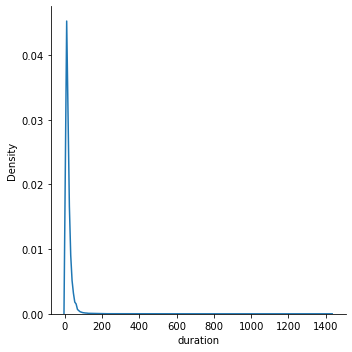

In [336]:
df_train, y_train = read_dataframe(data_sources[0], categorical_features=categorical_features, numerical_features=numerical_features, target=target, verbose=True)
df_val, y_val = read_dataframe(data_sources[1], categorical_features=categorical_features, numerical_features=numerical_features, target=target)

# Encoding

In [312]:
dv = DictVectorizer()

In [313]:
train_dicts = df_train.to_dict(orient='records')
val_dicts = df_val.to_dict(orient='records')

In [314]:
X_train = dv.fit_transform(train_dicts)
X_val = dv.transform(val_dicts)

In [315]:
print(f'Number of caterories in df_train: {dv.get_feature_names_out().shape}')

Number of caterories in df_train: (525,)


In [316]:
y_train = y_train[target].values
y_val = y_val[target].values

# Lineal regression

In [317]:
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

In [318]:
y_pred = lr.predict(X_train)

C:\Users\MARCOS\anaconda3\envs\mlops-zoomcamp\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\MARCOS\anaconda3\envs\mlops-zoomcamp\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


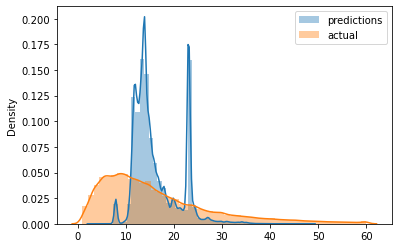

In [319]:
sns.distplot(y_pred, label='predictions')
sns.distplot(y_train, label='actual')
plt.legend()

Check performance in training dataset with rmse (return rmse, so is interpreted as the mean error in minutes)

In [320]:
mean_squared_error(y_train,y_pred, squared=False)

10.528643263699815

The performance of this baseline model is bad. We can use other features, or change the 

# Validation framework
We will use datasets from different months for train and validation

In [323]:
y_pred = lr.predict(X_val)

In [324]:
mean_squared_error(y_val,y_pred, squared=False)

11.01458930840019

# Other models

In [148]:
lr = Lasso(alpha=0.01)
lr.fit(X_train, y_train)
y_pred = lr.predict(X_val)
mean_squared_error(y_val, y_pred, squared=False)

10.812725703916977

In [149]:
lr = Ridge()
lr.fit(X_train, y_train)
y_pred = lr.predict(X_val)
mean_squared_error(y_val, y_pred, squared=False)

10.860753390359754

# Feature engineering
Combine PU and DO (interaction features)

In [151]:
df_train['PU_DO'] = df_train['PULocationID'] + '_' + df_train['DOLocationID']
df_val['PU_DO'] = df_val['PULocationID'] + '_' + df_val['DOLocationID']

In [152]:
categorical = ['PU_DO'] #'PULocationID', 'DOLocationID']

In [153]:
dv = DictVectorizer()

train_dicts = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dicts)

val_dicts = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dicts)

In [154]:
lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_val)

mean_squared_error(y_val, y_pred, squared=False)

7.479581745570146

Save the best result

In [165]:
import os
if not os.path.exists("./models"):
    os.makedirs("./models")

with open('models/lin_reg_green.bin','bw') as f_out:
    pickle.dump((dv,lr), f_out)

In [164]:
lr = Lasso(0.01)
lr.fit(X_train, y_train)

y_pred = lr.predict(X_val)

mean_squared_error(y_val, y_pred, squared=False)

11.167275941179728